In [229]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [230]:
df=pd.read_csv('dengue_bioactivity_dataset.csv')

In [231]:
def split_test_train(df):
    #Split input output
    X=df.drop(columns=['molecule_chembl_id','pIC50'])
    y=df['pIC50']
    #Split train and test set
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=123)
    return X_train, X_test, y_train, y_test   

In [232]:
X_train, X_test, y_train, y_test=split_test_train(df)

In [233]:
def baseline(y_train):
    baseline_prediction=np.mean(y_train)
    baseline_mse=mean_squared_error(y_train,np.ones(len(y_train))*baseline_prediction)
    return baseline_mse, baseline_prediction

In [234]:
baseline_mse, baseline_prediction = baseline(y_train)

In [235]:
baseline_mse

0.2360655764266686

## Linear Regression

In [236]:
def fit_linear_model(X_train, y_train,
              X_test, y_test):
    
    #Make linear regression object
    lr=LinearRegression()
    
    #Make cross validation score
    scores = cross_val_score(estimator = lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         scoring = "neg_mean_squared_error")
    cv_score = -np.mean(scores)
    
    #Fitting model
    lr.fit(X = X_train,
       y = y_train)
    
    # find train score
    y_train_pred = lr.predict(X_train)
    train_score = mean_squared_error(y_train, y_train_pred)
    r2_train_score=r2_score(y_train, y_train_pred)
    
    # find test score
    y_test_pred = lr.predict(X_test)
    test_score = mean_squared_error(y_test, y_test_pred)
    r2_test_score=r2_score(y_test, y_test_pred)

    # Extract the coefficient
    coef_ = lr.coef_
    intercept_ = lr.intercept_
    lr_params = np.append(coef_, intercept_)

    lr_params_df = pd.DataFrame(lr_params,
                                index = list(X_train.columns) + ["constant"],
                                columns = ["coefficient"])
    
    return lr, train_score, cv_score, test_score, lr_params_df, r2_train_score, r2_test_score

In [247]:
lr, train_score, cv_score, test_score, lr_params_df, r2_train_score, r2_test_score= fit_linear_model(X_train, y_train, X_test, y_test)
print(f"train score: {train_score}, cv score: {cv_score}, test_score: {test_score}")
linear_regression_model={'train_score': train_score,
            'cv_score':cv_score,
            'test_score':test_score}

train score: 0.06945994068432937, cv score: 2.2006617796264395e+20, test_score: 6.091904314899194e+20


In [238]:
print(f'r2_train_score:{r2_train_score},r2_test_score:{r2_test_score}')

r2_train_score:0.7057599768007412,r2_test_score:-2.1549580581270153e+21


Using linear regression, it cannot passed the benchmark value. The model have high variance due to relatively high disimilarity between train, CV, and test score. It is an indication that the model is overfit and need to conduct regularization (Regression Shrinkage Methods). 
<br><br>This model has high dimensioal feature, so best subset selection, forward and backward elimination will computationally expensive to conducted. Ridge Linear Regression is used because it is suitable for data with many predictor. We will create model using Ridge Linear Regression method.

## Ridge Linear Regression

In [252]:
def ridge_best_param(X_train,y_train):
    alphas = [0.5, 1.0, 2.5, 5.0, 10.0, 15.0, 
          25.0, 40.0, 60.0, 70.0, 75.0]

    # Made model with variation on alpha value
    ridge = Ridge()

    param_space = {"alpha": alphas}
    
    # Lakukan grid search dengan CV
    cv_ridge = GridSearchCV(estimator = ridge,
                            param_grid = param_space,
                            scoring = "neg_mean_squared_error",
                            cv = 10)

    # Fit searching
    cv_ridge.fit(X = X_train,
                 y = y_train)
    
    return cv_ridge.best_params_

In [253]:
best_alpha=ridge_best_param(X_train,y_train)
print(f'The best parameter alpha is {best_alpha}')

The best parameter alpha is {'alpha': 70.0}


In [260]:
def ridge_model(X_train, y_train,
                X_test, y_test,
                alpha):
    # Create object 
    estimator = Ridge(alpha = alpha)

    # Model Fitting
    estimator.fit(X = X_train,
                  y = y_train)
    
    # Prediction score in train data
    y_pred_train = estimator.predict(X_train)
    train_score = mean_squared_error(y_train, y_pred_train)
    r2_train_score=r2_score(y_train, y_pred_train)

    # cross validation
    scores = cross_val_score(estimator = estimator,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = "neg_mean_squared_error")
    cv_score = -np.mean(scores)

    # Prediction score in test data
    y_pred_test = estimator.predict(X_test)
    test_score = mean_squared_error(y_test, y_pred_test)
    r2_test_score=r2_score(y_test, y_pred_test)

    # Show the parameter
    coef_ = estimator.coef_
    intercept_ = estimator.intercept_
    params = np.append(coef_, intercept_)

    params_df = pd.DataFrame(params,
                             index = list(X_train.columns) + ["constant"],
                             columns = ["coefficient"])

    mse_score = [train_score, cv_score, test_score]

    return estimator, mse_score, params_df,r2_train_score,r2_test_score

In [266]:
alpha = best_alpha['alpha']
_, mse_score, ridge_param_1,ridge_train_r2, ridge_test_r2  = ridge_model(X_train = X_train,
                                          y_train = y_train,
                                          X_test = X_test,
                                          y_test = y_test,
                                          alpha = alpha)

train_score, cv_score, test_score = mse_score

print(f"Train: {train_score}, CV: {cv_score}, Test: {test_score}")
ridge_regression_model={'train_score': train_score,
            'cv_score':cv_score,
            'test_score':test_score}

Train: 0.13215109742846443, CV: 0.17106016170181654, Test: 0.19515304473701056


In [262]:
print(f'r2_train_score:{ridge_train_r2},r2_test_score:{ridge_test_r2}')

r2_train_score:0.4401932741366218,r2_test_score:0.30966311257467305


In [264]:
#Visualization of alphas parameter tuning
def visalization_of_alpha(X_train,y_train,X_test,y_test):
    alphas = [0.5, 1.0, 2.5, 5.0, 10.0, 15.0, 
              25.0, 40.0, 60.0, 70.0, 75.0]

    mse_list = []
    model_list = []

    for alpha in alphas:
        _, mse_i, model_i,r2_train_score,r2_test_score = ridge_model(X_train = X_train,
                                        y_train = y_train,
                                        X_test = X_test,
                                        y_test = y_test,
                                        alpha = alpha)
    
        mse_list.append(mse_i)
        model_list.append(model_i)
        
        # Plot error
    mse_list = np.array(mse_list)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

    ax.plot(alphas, mse_list[:, 0], c="r", marker=".", label="Train")
    ax.plot(alphas, mse_list[:, 1], c="g", marker=".", label="CV")
    ax.plot(alphas, mse_list[:, 2], c="b", marker=".", label="Test")

    ax.set_xlabel("alpha")
    ax.set_ylabel("MSE")

    plt.grid()
    plt.legend()
    plt.show()

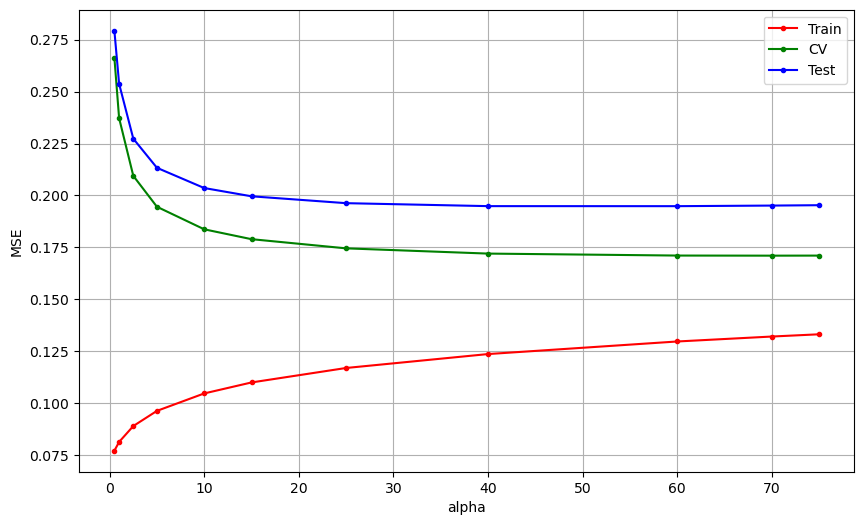

In [265]:
visalization_of_alpha(X_train,y_train,X_test,y_test)

As we can see, using ridge regularization the variance of the model become lesser and model tend to be not overfitting.

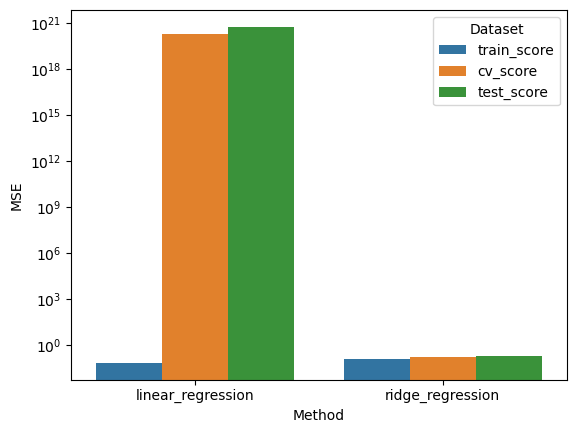

In [251]:
#Score Comparasion visualization
method_list=['linear_regression','linear_regression','linear_regression','ridge_regression','ridge_regression','ridge_regression']
dataset_list=[]
mse_lists=[]
for key in linear_regression_model.keys():
    dataset_list.append(key)
    mse_lists.append(linear_regression_model[key])

for key in ridge_regression_model.keys():
    dataset_list.append(key)
    mse_lists.append(ridge_regression_model[key])
compa=pd.DataFrame(columns=['Method','Dataset','MSE'])
compa['Method']=method_list
compa['Dataset']=dataset_list
compa['MSE']=mse_lists
vis=sns.barplot(data=compa,x='Method',y='MSE',hue='Dataset')
vis.set_yscale("log")
